In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from libs.utils import montage
from libs import gif
import IPython.display as ipyd

plt.style.use('ggplot')

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [3]:
from libs.datasets import MNIST
ds =MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
print(ds.X.shape)

(70000, 784)


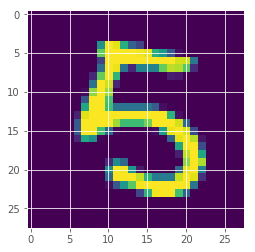

In [5]:
plt.imshow(ds.X[0].reshape((28,28)))

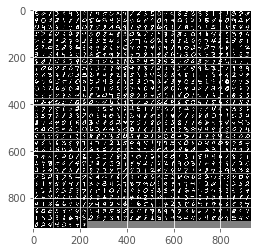

In [6]:
imgs = ds.X[:1000].reshape((-1, 28,28))
plt.imshow(montage(imgs), cmap='gray')

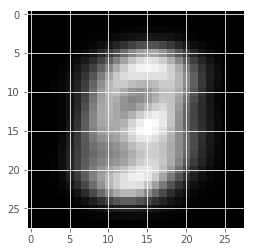

In [14]:
mean_img = np.mean(ds.X, axis=0)
plt.figure()
plt.imshow(mean_img.reshape((28,28)), cmap='gray')

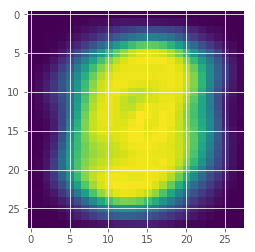

In [12]:
std_img = np.std(ds.X, axis= 0)

plt.figure()
plt.imshow(std_img.reshape(28,28))

In [170]:
tf.reset_default_graph()

In [171]:
dimensions = [784, 512, 256,128, 64]

In [172]:
n_features = ds.X.shape[1]

In [173]:
X = tf.placeholder(tf.float32, [None, n_features])

In [174]:
current_input = X
n_input = n_features
Ws = []
bs = []

for layer_i, n_output in enumerate(dimensions[1:]):
    
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer= tf.random_normal_initializer(mean=0.0, stddev=0.02))
        
        b = tf.get_variable(
            name='b',
            shape=[n_output],
            initializer= tf.constant_initializer())
        
        h = tf.add(tf.matmul(current_input, W), b)
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        n_input = n_output

In [175]:
print(current_input.get_shape())

(?, 64)


In [178]:
print(bs[0])

Tensor("encoder/layer/0/b/read:0", shape=(512,), dtype=float32)


In [179]:
Ws = Ws[::-1]

dimensions = dimensions[::-1]
print(dimensions)

[64, 128, 256, 512, 784]


In [180]:
for layer_i, n_output in enumerate(dimensions[1:]):
    
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = tf.transpose(Ws[layer_i])
        b = tf.get_variable(
                name='b',
                shape=[n_output],
                initializer=tf.constant_initializer())
        h = tf.add(tf.matmul(current_input, W),b)
        
        current_input = tf.nn.relu(h)
        
        n_input = n_output
        
        

In [181]:
Y = current_input

In [182]:
cost = tf.reduce_sum(tf.squared_difference(X, Y), 1)
print(cost.get_shape())

(?,)


In [183]:
cost = tf.reduce_mean(cost)

In [184]:
learning_rate = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [185]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0 29.2644
1 28.0122
2 28.2446
3 27.833
4 28.0691
5 27.0025
6 26.9196
7 26.6681
8 26.008
9 27.1116
10 27.0333
11 25.7911
12 26.8048
13 25.6798
14 25.6198
15 24.9946
16 26.6953
17 25.9125
18 25.706
19 25.5904
20 25.3622
21 25.4249
22 24.8199
23 25.3158
24 25.942
25 25.4942
26 25.5278
27 24.0758
28 23.8128
29 24.6024
30 24.7435
31 25.7357
32 24.3015
33 24.0433
34 24.3345
35 23.54
36 23.6746
37 24.1874
38 24.3282
39 23.7932
40 22.9732
41 24.0878
42 23.3801
43 24.2818
44 23.6266
45 23.1981
46 23.5385
47 24.0703
48 23.439
49 23.3851
50 23.5444
51 23.3753
52 23.4833
53 23.584
54 23.1094
55 24.0252
56 23.2033
57 23.2897
58 22.4237
59 23.9187
60 23.519
61 23.2122
62 22.7291
63 23.345
64 22.7187
65 23.3323
66 23.8111
67 23.0462
68 23.0522
69 22.5002
70 22.8125
71 22.9764
72 22.9015
73 22.7966
74 22.7215
75 22.3855
76 22.8507
77 22.9078
78 21.9591
79 21.9704
80 22.3293
81 22.3054
82 22.7927
83 22.0776
84 22.5366
85 22.1295
86 22.7815
87 22.2587
88 22.0931
89 22.461
90 22.0787
91 22.804
92 23.673


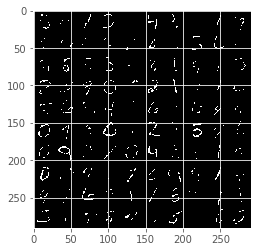

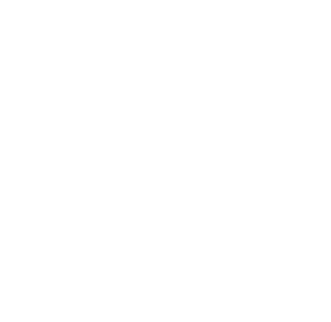

In [191]:
batch_size = 100
n_epochs = 100

examples = ds.X[:100]

imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train. next_batch():
        sess.run(optimizer, feed_dict = {X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict = {X: examples - mean_img})
    recon = np.clip((recon+mean_img).reshape((-1,28,28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [192]:
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
          height=500, width=500)

In [193]:
tf.reset_default_graphfault_graph()

In [194]:
X = tf.placeholder(tf.float32, [None, n_features])


In [195]:
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

In [196]:
n_filters = [16,16,16]
filter_sizes = [4,4,4]

In [200]:
current_input = X_tensor

n_input = 1
Ws = []
shapes = []

for layer_i, n_output in enumerate(n_filters):
   with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        shapes.append(current_input.get_shape().as_list())
        
        W = tf.get_variable(
                name='W',
                shape=[
                    filter_sizes[layer_i],
                    filter_sizes[layer_i],
                    n_input,
                    n_output],
                initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        h = tf.nn.conv2d(current_input, W, strides = [1,2,2,1], padding='SAME')
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output

In [201]:
Ws.reverse()
shapes.reverse()
n_filters.reverse()
n_filters  = n_filters[1:] + [1]
print(n_filters)
print(filter_sizes)
print(shapes)

[16, 16, 1]
[4, 4, 4]
[[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


In [203]:
for layer_i, shape in enumerate(shapes):
    
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = Ws[layer_i]
        h = tf.nn.conv2d_transpose(current_input, W,
                    tf.pack([tf.shape(X)[0], shape[1],shape[2], shape[3]]),
                    strides=[1,2,2,1], padding='SAME')
        
        current_input = tf.nn.relu(h)

In [204]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

In [ ]:
tf.pack